# Regressão Linear

Os objetivos dessa aula são:
- praticar o ajuste de modelos de regressão linear
- introduzir ferramentas para avaliação de modelos usando um conjunto de teste e validação cruzada
- praticar a seleção de modelos
- introduzir o conceito de regularização


*Parte do material dessa aula foi adaptado do livro [__Python Data Science Handbook__ (capítulo 5)](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html) de Jake VanderPlas; o conteúdo original está hospedado [no GitHub](https://github.com/jakevdp/PythonDataScienceHandbook). O texto do livro está disponível sob a licença Creative Commons [CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode) e o código sob a [licença MIT](https://opensource.org/licenses/MIT). *

## Regressão linear simples

Vamos começar ajustando um modelo linear simples, contendo apenas um preditor. Em primeiro lugar, vamos importar os pacotes padrão:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

Agora veremos como usar o pacote `sklearn` para ajustar modelos de regressão linear. Nosso modelo inicial apresenta apenas um preditor $x$:
\begin{equation}
y = \beta_0 + \beta_1x
\end{equation}
O coeficiente $\beta_0$ é conhecido como _ordenada na origem_ (_intercept_) e $\beta_1$ determina a _inclinação_ (_slope_) da reta.
Na célula abaixo, vamos criar um conjunto de pares $(x, y)$, em que os valores de $y$ são determinados por um modelo linear em $x$ somado a um termo de ruído. Escolhemos uma inclinação $\beta_1 = 2$ e ordenada na origem $\beta_0 = -5$


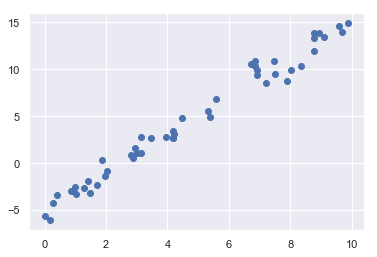

In [3]:
rng = np.random.RandomState(1)
# x é um vetor aleatório de 50 posições
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

Para ajustar o modelo de regressão, usaremos a classe [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) do [`sklearn`](https://scikit-learn.org/stable/documentation.html). Essa classe segue a interface usual do `sklearn`, contendo um método `fit` para ajuste do modelo e um método `predict` para estimativa de novos valores a partir dos preditores.

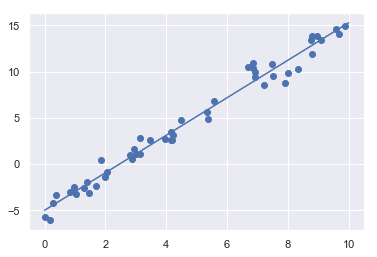

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
# ajuste do modelo
model.fit(x[:, np.newaxis], y)

#conjunto de novos valores para x
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [5]:
print("Inclinação:        ", model.coef_[0])
print("Ordenada na origem:", model.intercept_)

Inclinação:         2.027208810360695
Ordenada na origem: -4.998577085553202


Observamos que os coeficientes estimados são bastante próximos dos valores reais.

Objetos do tipo `LinearRegression` são capazes de ajustar modelos multivariados (com mais de um preditor). No exemplo abaixo, geramos uma matriz de preditores $X$ de tamanho $100 x 3$ contendo $100$ exemplos de treinamento, cada exemplo contendo $3$ preditores. Em seguida, os valores de $y$ são calculados de acordo com a equação:
\begin{equation}
y = 1.5x_1 - 2x_2 + x_3 + \epsilon
\end{equation}
em $\epsilon$ é um termo de ruído. Em seguida, um novo modelo é ajustado.

In [6]:
rng = np.random.RandomState(1)
X = 10*rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.]) + 1.2*rng.randn(100)

model.fit(X, y)
print("Coeficientes:      ", model.coef_)
print("Ordenada na origem:", model.intercept_)


Coeficientes:       [ 1.47791451 -1.97146913  0.96709651]
Ordenada na origem: 0.6874800158921792


Novamente, os coeficentes estimados são bastante próximos dos parâmetros reais usados para gerar os dados. Também podemos calcular os valores do erro quadrático médio e do coeficiente de determinação $R^2$, usando funções do pacote `sklearn.metrics`:

In [7]:
from sklearn.metrics import mean_squared_error, r2_score
print("Erro quadrático médio:", mean_squared_error(y, model.predict(X)))
print("R^2:", r2_score(y, model.predict(X)))


Erro quadrático médio: 1.3217105141277896
R^2: 0.9794622088499816


## Avaliando um modelo com um conjunto de teste

O coeficiente $R^2$ mede o quanto os valores $\hat{y}$ preditos pelo modelo se aproximam dos valores $y$ da variável alvo ($R^2 = 1$ indica predição perfeita). Como o calculamos o coeficiente sobre os mesmos pares $(\mathbf{x}, y)$ usados em treinamento, esse cálculo acaba sendo excessivamente otimista. Podemos produzir uma estimativa mais realista da qualidade do modelo ao guardar parte dos dados para avaliação, sem utilizá-los em treinamento.

O `sklearn` contém funções para essa separação de dados, dentro do pacote `model_selection`. No trecho abaixo, vamos repetir o ajuste do modelo linear, mas agora dividindo os dados em duas partes de mesmo tamanho.

In [8]:
from sklearn.model_selection import train_test_split

# divide os dados em duas partições com o mesmo número de exemplos em cada uma
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5, test_size=0.5)

# ajusta o modelo sobre a partição de treinamento
model.fit(X1, y1)

# imprime os coeficientes resultantes
print("Coeficientes:      ", model.coef_)
print("Ordenada na origem:", model.intercept_)
# calcula R^2 sobre a partição de teste
print("Erro quadrático médio:", mean_squared_error(y2, model.predict(X2)))
print("R^2:", r2_score(y2, model.predict(X2)))


Coeficientes:       [ 1.50070768 -1.9705827   0.94440114]
Ordenada na origem: 0.6272254488083244
Erro quadrático médio: 1.436465140496027
R^2: 0.9745405895694057


## Avaliando um modelo com validação cruzada

Uma desvantagem de avaliar um modelo com um conjunto de teste separado é que reduzimos significativamente a quantidade de dados disponível para treinamento. Esse problema pode ser amenizado com o uso da _validação cruzada_ com $n$ partições (_folds_). Quando usamos validação cruzada, dividimos os dados em $n$ partições. O algoritmo de treinamento será executado $n$ vezes e, em cada iteração, uma das partições será reservada para avaliação e as outras $n-1$ partições serão usadas para treinamento. É usual adotarmos $n = 5$ ou $n = 10$.

O `sklearn` contém algumas funções para treinamento de modelos usando validação cruzada, permitindo a escolha da função de avaliação calculada a cada iteração de treinamento. No exemplo abaixo, vamos calcular o coeficiente de determinação $R^2$ (`r2`).


In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, scoring="r2", cv=10)

print("R^2 médio:", scores.mean())
print("desvio padrão:", scores.std())
print("R^2 máximo:", scores.max())
print("R^2 mínimo:", scores.min())


R^2 médio: 0.9755892564094758
desvio padrão: 0.010958913426137707
R^2 máximo: 0.99081615370346
R^2 mínimo: 0.9604011289320934


Você pode consultar a documentação de [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) e do parâmetro [`scoring`](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) para aprender sobre outras possibilidades de métricas de avaliação.

## Regressão com funções de base polinomiais

Em certas situações, a função de regressão não é linear em relação aos atributos $x_1, x_2, \ldots, x_p$. Mesmo nesse caso, podemos usar regressão linear ao adicionar transformações não lineares de atributos. O conjunto de preditores é aumentado com atributos derivados $x_n = f_n(x_i)$, em que $f_n$ é uma função não linear e $x_i$ é um dos atributos originais. O modelo continua sendo linear no conjunto aumentado de atributos, sendo determinado pela equação:
\begin{equation}
y = \beta_0 + \sum_{i=1}^{p^{\prime}} \beta_i x_i
\end{equation}
em que $p^{\prime} > p$ é a nova dimensão do vetor de atributos, após a adição dos atributos derivados.

As funções $f_n(x_i)$ são chamadas de _funções de base_ (_basis functions_) porque elas geram o espaço dos valores observados de $y$ (em analogia com a base de um espaço vetorial).

No exemplo abaixo, vamos gerar diversos pontos de uma função _seno_, perturbando os pontos com algum ruído:

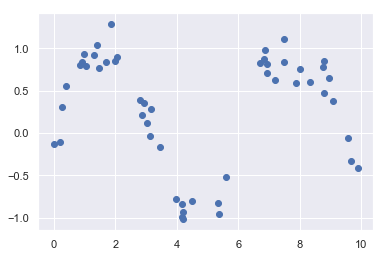

In [10]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.2 * rng.randn(50)
plt.scatter(x, y)

Agora, vamos tentar aproximar essa função com um aproximação polinomial. Para isso, vamos transformar a variável $x$ com funções $f_n(x) = x^n$ (funções de base polinomiais).

Coeficientes:       [ 2.54167413e+00 -2.83992846e+00  2.14479447e+00 -9.77866025e-01
  2.40715401e-01 -3.15739136e-02  2.08899595e-03 -5.49598026e-05]
Ordenada na origem: -0.23414078262227672
Erro quadrático médio: 0.023726411738241797
R^2: 0.9458606124366004


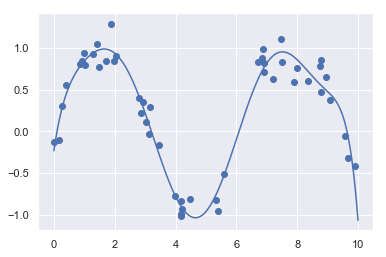

In [11]:
from sklearn.preprocessing import PolynomialFeatures

# grau determina quantas funções polinomiais vamos usar
grau = 8

# PolynomialFeatures gera a transformacao que aumenta o vetor
# de preditores com os atributos polinomiais
poli = PolynomialFeatures(grau, include_bias=False)
# vetor aumentado com os atributos polinomiais
x_poli = poli.fit_transform(x[:, np.newaxis])

# ajuste do modelo
poli_model = LinearRegression(fit_intercept=True)
poli_model.fit(x_poli, y)

# vamos gerar novos pontos x para avaliar o modelo gerado
xbase = np.linspace(0, 10, 1000)
# os novos pontos precisam ser aumentados também com os
# atributos polinomiais
xfit = poli.fit_transform(xbase[:, np.newaxis])
yfit = poli_model.predict(xfit)

print("Coeficientes:      ", poli_model.coef_)
print("Ordenada na origem:", poli_model.intercept_)
print("Erro quadrático médio:", mean_squared_error(y, poli_model.predict(x_poli)))
print("R^2:", r2_score(y, poli_model.predict(x_poli)))
plt.scatter(x, y)
plt.plot(xbase, yfit);


Como diagnóstico, é interessante visualizar os resíduos para tentar identificar algum padrão. Nós esperamos que os resíduos se distribuam de maneira aleatória em torno de zero. Caso os resíduos tenham algum padrão (por exemplo, resíduos positivos concentrando-se em uma parte do gráfico e resíduos negativos em outra) pode ser sinal de que o modelo não está suficientemente ajustado aos dados.

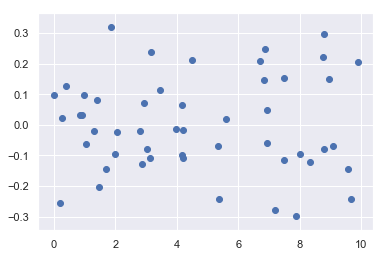

In [12]:
residuos = y - poli_model.predict(x_poli)
plt.scatter(x, residuos);

### Exercício 1

Varie o valor de `grau` no código acima e observe a variação de $R^2$. Use o procedimento de validação cruzada (VC), variando o valor de `grau` a cada aplicação de VC. Tente determinar qual o melhor valor de `grau` nesse caso.

## Regressão em crista (_ridge regression_)

O modelo de regressão linear que usamos até agora tem algumas limitações. Por exemplo, na presença de _colinearidade_ (dois ou mais atributos linearmente dependentes entre si), a estimativa dos coeficientes $\beta_i$ torna-se ambígua, pois diferentes conjuntos de coeficientes podem resultar da minimização do erro quadrático nessa situação. Uma solução para essa limitação é a introdução de _termos de regularização_, funções que são adicionadas à medida do erro para tornar mais estável a estimativa dos coeficientes.

No modelo de regressão linear sem regularização, a função minimizada depende apenas do valor ao quadrado dos erros de predição:
\begin{equation}
J(\beta_0, \beta_1, \ldots, \beta_p) = \sum_{i=1}^{N}(y_i - \beta_0 - \sum_{j=1}^{p} \beta_jx_{ij})^2
\end{equation}
em que o índice $i$ percorre os exemplos de treinamento e o índice $j$ percorre os atributos preditores.

Para regularizar a função $J(\beta_0, \beta_1, \ldots, \beta_p)$, introduzimos um termo $f(\beta_0, \beta_1, \ldots, \beta_p)$ que atua como penalização dos coeficientes:
\begin{equation}
J(\beta_0, \beta_1, \ldots, \beta_p) = \sum_{i=1}^{N}(y_i - \beta_0 - \sum_{j=1}^{p} \beta_jx_{ij})^2 - \alpha f(\beta_0, \beta_1, \ldots, \beta_p)$
\end{equation}
O papel da função $f$ é impor algum característica aos coeficientes estimados. Por exemplos, podemos tentar forçar que alguns dos coeficientes sejam zerados, gerando assim um modelo mais _esparso_. Isso facilita a interpretação do modelo, uma vez que uma quantidade menor de preditores é incluída. O parâmetro $\alpha$ permite ajustar o equilíbrio entre o termo de erro quadrático e o termo de penalização.

Na _regressão em crista_ (_ridge regression_), tentamos limitar a norma quadrática dos coeficientes:
\begin{equation}
J_{\text{ridge}}(\beta_0, \beta_1, \ldots, \beta_p) = \sum_{i=1}^{N}(y_i - \beta_0 - \sum_{j=1}^{p} \beta_jx_{ij})^2 - \alpha \sum_{j=0}^{p} \beta_j^2
\end{equation}

Vamos aplicar a regressão em crista ao problema anterior. No `sklearn`, o estimador de regressão em crista é implementado pela classe `Ridge`:



Coeficientes:       [ 2.45579799e-01  2.60974050e-01  9.37639171e-02 -2.31888271e-01
  8.54145392e-02 -1.32013737e-02  9.42748261e-04 -2.57203663e-05]
Ordenada na origem: 0.30719524662104863
Erro quadrático médio: 0.034400335433236263
R^2: 0.9215046458403517


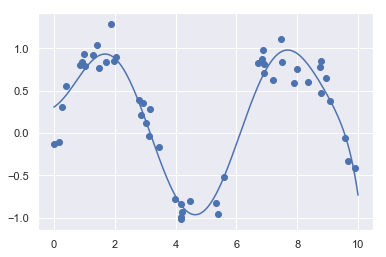

In [13]:
from sklearn.linear_model import Ridge

grau = 8
poli = PolynomialFeatures(grau, include_bias=False)
x_poli = poli.fit_transform(x[:, np.newaxis])

poli_model = Ridge(fit_intercept=True, alpha=4)
poli_model.fit(x_poli, y)

# vamos gerar novos pontos x para avaliar o modelo gerado
xbase = np.linspace(0, 10, 1000)
# os novos pontos precisam ser aumentados também com os
# atributos polinomiais
xfit = poli.fit_transform(xbase[:, np.newaxis])
yfit = poli_model.predict(xfit)

print("Coeficientes:      ", poli_model.coef_)
print("Ordenada na origem:", poli_model.intercept_)
print("Erro quadrático médio:", mean_squared_error(y, poli_model.predict(x_poli)))
print("R^2:", r2_score(y, poli_model.predict(x_poli)))
plt.scatter(x, y)
plt.plot(xbase, yfit);

## O conjunto de dados `diabetes`

Agora vamos praticar o ajuste de modelos de regressão com o conjunto de dados `diabetes`, utilizado no artigo: [_Least Angle Regression_](https://web.stanford.edu/~hastie/pub.htm), Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani,  _Annals of Statistics_ (2004).

Vamos ler o conjunto de dados com a biblioteca `pandas`:

In [14]:
import pandas as pd

df = pd.read_csv("diabetes.csv")
print(df.columns)


Index(['age', 'sex', 'bmi', 'map', 'tc ', 'ldl', 'hdl', 'tch', 'ltg', 'glu',
       'y'],
      dtype='object')


Esse conjunto de dados foi coletado em um estudo em que 442 pacientes de diabetes foram acompanhados durante um ano. No início do estudo, diferentes atributos foram medidos para cada paciente. Ao final de um ano, os médicos reavaliaram cada paciente, atribuindo uma métrica (variável `y`) para o avanço da doença (quanto maior `y`, pior o estado do paciente). Os atributos medidos foram:
- `age`: idade em anos
- `sex`: masculino ou feminino
- `bmi`: índice de massa corporal
- `map`: pressão sanguínea média
- `tc`, `ldl`, `hdl`, `tch`, `ltg`, `glu`: medidas serológicas.

Os objetivos do estudo eram:
- determinar um modelo que, dadas informações clínicas do paciente, fornecesse uma estimativa da evolução da doença ao final de um ano.
- encontrar, entre os atributos medidos, quais influenciam diretamente na evolução do paciente.

### Exercício 2

Nesse exercício você vai ajustar um modelo de regressão linear sobre o conjunto de dados `diabetes`. Você deve buscar por um modelo que tenha boa capacidade de predição; tente identificar quais são os atributos mais relevantes para esse problema e como eles afetam a variável alvo $y$.

Crie um novo arquivo do jupyter notebook apenas para responder este exercício, que será entregue na atividade correspondente a esta aula.

Separe um conjunto de dados para teste, contendo 30% dos exemplos do conjunto de dados. **Não use** esse conjunto de dados de teste durante a fase de ajuste do(s) seu(s) modelo(s), ele será usado somente para avaliação final.

Você pode começar sua análise ajustando alguns modelos simples (com um preditor) para cada atributo. Tente identificar se a relação entre $y$ e o preditor é linear ou se é necessário acrescentar termos polinomiais (quadrado, cubo, etc). Em seguida, tente combinar mais atributos em um único modelo. Use o procedimento de validação cruzada para comparar diferentes modelos (com conjuntos diferentes de preditores). Experimente ajusta o modelo sem regularização ou com regularização (regressão em crista).

Pode ser interessante visualizar os coeficientes de correlação entre atributos diferentes, para identificar potenciais problemas com colinearidade. O coeficiente de correlação $\rho$ entre duas variáveis é um número que varia entre $-1$ e $+1$ e indica o quanto as duas variáveis estão alinhadas sobre uma reta. Um $\rho$ próximo a zero indica baixa correlação entre as variáveis. Um $\rho$ próximo de $+1$ indica uma forte relação linear e crescente (quando uma variável aumenta de valor, a segunda variável aumenta também). Um $\rho$ próximo de $-1$ indica uma forte relação linear e _decrescente_ (quando uma variável aumenta de magnitude, a segunda variável diminui de valor).

A biblioteca `pandas` permite o cálculo do coeficiente de correlação para todos os pares de colunas por meio do método `corr`:

In [16]:
df.corr()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
age,1.000000,0.177463,0.200554,0.350859,0.262524,0.221711,-0.106973,0.221017,0.207880,0.296235,0.197822
sex,0.177463,1.000000,0.098079,0.261508,0.027790,0.134695,-0.394584,0.337524,0.161618,0.203277,0.037401
bmi,0.200554,0.098079,1.000000,0.397985,0.287829,0.295494,-0.371172,0.459068,0.417252,0.384664,0.561382
map,0.350859,0.261508,0.397985,1.000000,0.275224,0.205638,-0.191033,0.280799,0.317884,0.381219,0.416241
tc,0.262524,0.027790,0.287829,0.275224,1.000000,0.878793,0.015308,0.520674,0.437249,0.332173,0.232429
ldl,0.221711,0.134695,0.295494,0.205638,0.878793,1.000000,-0.197435,0.652283,0.318770,0.286483,0.195834
hdl,-0.106973,-0.394584,-0.371172,-0.191033,0.015308,-0.197435,1.000000,-0.789694,-0.405612,-0.290863,-0.410022
tch,0.221017,0.337524,0.459068,0.280799,0.520674,0.652283,-0.789694,1.000000,0.563574,0.413700,0.448931
ltg,0.207880,0.161618,0.417252,0.317884,0.437249,0.318770,-0.405612,0.563574,1.000000,0.403575,0.522981
glu,0.296235,0.203277,0.384664,0.381219,0.332173,0.286483,-0.290863,0.413700,0.403575,1.000000,0.350792


Quando você tiver gerado um ou mais modelos que tenham bom desempenho, avalie esses modelos no conjunto de teste. Compare os valores de $R^2$ estimados usando validação cruzada (VC) com o valor calculado sobre o conjunto de teste. Os modelos tem degradação de desempenho notável no conjunto de teste? A ordem de desempenho entre os modelos é a mesma usando VC no conjunto de treinamento e avaliando no conjunto de teste?

Entregue um notebook do jupyter contendo todo o código para gerar e avaliar os modelos. Documente o processo que você usou para selecionar os atributos incluídos no(s) modelo(s).